# Sentiment Analysis using fine-tuned BERT
## Naiyu Jiang

To deepen our understanding of ethnic minorities' opinions towards different topics across different groups, I conduct a sentiment analysis on Chinese social media posts using a fine-tuned pre-trained BERT model. Other than BERT, I also try LSTM sentiment analysis model. 



In [ ]:
!pip install -U git+https://github.com/huggingface/transformers
#!pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
import torch # pip install torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig # pip install tranformers==2.4.1
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
# import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-zcitqmyk
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-zcitqmyk
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 895 kB 2.8 MB/s 
     |████████████████████████████████| 6.5 MB 63.5 MB/s 
     |████████████████████████████████| 67 kB 6.8 MB/s 
     |████████████████████████████████| 596 kB 65.3 MB/s 
  Created wheel for transformers: filename=transformers-4.18.0.dev0-py3-none-any.whl size=3864825 sha256=ac3b9b5a658f18805c55b3329d73b6c3ae8bddde94442188788b3b32f8876567
  Stored in directory: /tmp/pip-ephem-wheel-cache-79f0euzd/wheels/35/2e/a7/d819e3310040329f0f47e57c9e3e7a7338aa5e74c49acfe522
Successfully built transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully unin

In [ ]:
%matplotlib inline

In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences

Launch GPU: 

In [ ]:
gpu = torch.cuda.is_available()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if gpu:
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)

In [ ]:
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Text Clssification using LSTM 


In [ ]:
#coding=utf-8
%matplotlib inline
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import jieba as jb
import re

In [ ]:
path_ex = 'drive/MyDrive/Colab Notebooks/sentiment/weibo_senti_100k.csv'
df_ex = pd.read_csv(path_ex)

In [ ]:
df_ex.sample(10)

,label,review
17701,1,圣诞餐在@LaSushi乐寿司 吃shabu shabu[太开心]so yum[馋嘴][馋嘴]
68921,0,自拍很high[心][抱抱][酷]（and 真心觉得mac air特别烂[鄙视] 用了这几年...
58916,1,共购五本，伙伴们有时间来我这欣赏或免费赠送，哈哈！[嘻嘻]@寻梦婺源 @婺源熹园官方微博@婺...
72321,0,我为了?心别人，定制了最炫民族风的彩铃，第一次玩彩铃，业务生疏，不小心设置成了只给自己听，我...
8275,1,它本来就来自本山大叔的家乡[嘻嘻]//@哗啦啦网_上海: ?店名叫人?想到本山大叔啊
114139,0,师傅，那必须是你野徒弟啊，哈哈哈//@不吃猫的鱼儿：是，谁这么有艺术细胞[伤心] //@跨媒...
114670,0,女神[泪]//@松轶:Happy Valentines Day ！[心][心][心]
107890,0,哇！被偷拍了[衰]
92820,0,我觉得我一定是一个吃货，每天一空下来就总会思考的一个问题是，中午吃什么，晚上吃什么？[泪]。...
54074,1,哟嚯[哈哈][哈哈]//@名人名言博览:转发微博


In [ ]:
# delete components other than Chinese characters
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line
 
def stopwordslist(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]  
    return stopwords  

# load Chinese stopwords
stopwords = stopwordslist("drive/MyDrive/Colab Notebooks/sentiment/stopwords.txt")

In [ ]:
df_ex['clean_sentence'] = df_ex['review'].apply(remove_punctuation)
df_ex.sample(10)

,label,review,clean_sentence
15358,1,[偷笑][偷笑]这些可爱的海豚宝宝都COS哪位笑星~大伙看出来了么？[哈哈]编辑短信A+最想...,偷笑偷笑这些可爱的海豚宝宝都COS哪位笑星大伙看出来了么哈哈编辑短信A最想说的话发送到106...
67115,0,试着用jawbone up2纪录了睡眠时间，深度睡眠时间很短，质量很差。[泪],试着用jawboneup2纪录了睡眠时间深度睡眠时间很短质量很差泪
55845,1,家里买了家庭影院折腾到现在，又见海底捞[爱你],家里买了家庭影院折腾到现在又见海底捞爱你
91797,0,其实我更想是窦唯。[泪]//@竹聿名:恭硕良作曲，林忆莲唱，拿奖。多美妙。,其实我更想是窦唯泪竹聿名恭硕良作曲林忆莲唱拿奖多美妙
76930,0,"NND, what can you do when you have a stupid ma...",NNDwhatcanyoudowhenyouhaveastupidmanager怒
103207,0,事态发展到这种成程度，刚冲过了红海，驶向了蓝海，前方还是红海[晕][嘻嘻][熊猫][兔子][...,事态发展到这种成程度刚冲过了红海驶向了蓝海前方还是红海晕嘻嘻熊猫兔子带着微博去旅行
21127,1,[嘻嘻][干杯],嘻嘻干杯
113777,0,什么也不想说，都是眼泪！！[泪],什么也不想说都是眼泪泪
34421,1,这礼物杠杠的！[爱你],这礼物杠杠的爱你
78069,0,孩子就是孩子//@门沙沙：[泪],孩子就是孩子门沙沙泪


In [ ]:
# cut words and filter stopwords
df_ex['cut_sent'] = df_ex['clean_sentence'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
df_ex.head()

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.892 seconds.
Prefix dict has been built successfully.


,label,review,clean_sentence,cut_sent
0,1,﻿更博了，爆照了，帅的呀，就是越来越爱你！生快傻缺[爱你][爱你][爱你],更博了爆照了帅的呀就是越来越爱你生快傻缺爱你爱你爱你,更博 爆照 帅 越来越 爱 生快 傻 缺爱 爱 爱
1,1,@张晓鹏jonathan 土耳其的事要认真对待[哈哈]，否则直接开除。@丁丁看世界 很是细心...,张晓鹏jonathan土耳其的事要认真对待哈哈否则直接开除丁丁看世界很是细心酒店都全部OK啦,张晓鹏 jonathan 土耳其 事要 认真对待 直接 开除 丁丁 看 世界 很 细心 酒店...
2,1,姑娘都羡慕你呢…还有招财猫高兴……//@爱在蔓延-JC:[哈哈]小学徒一枚，等着明天见您呢/...,姑娘都羡慕你呢还有招财猫高兴爱在蔓延JC哈哈小学徒一枚等着明天见您呢李欣芸SharonLee...,姑娘 都 羡慕 招财猫 高兴 爱 蔓延 JC 小 学徒 一枚 明天 见 李欣芸 Sharon...
3,1,美~~~~~[爱你],美爱你,美爱
4,1,梦想有多大，舞台就有多大![鼓掌],梦想有多大舞台就有多大鼓掌,梦想 大 舞台 大 鼓掌


In [ ]:
MAX_NB_WORDS = 21128
MAX_SEQUENCE_LENGTH = 80
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_ex['cut_sent'].values)
word_index = tokenizer.word_index
print('There are total %s different words.' % len(word_index))

There are total 222953 different words.


In [ ]:
X = tokenizer.texts_to_sequences(df_ex['cut_sent'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
Y = pd.get_dummies(df_ex['label']).values

print(X.shape)
print(Y.shape)

(119988, 80)
(119988, 2)


In [ ]:
# split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

In [ ]:
# define model
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 80, 100)           2112800   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 80, 100)          0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 2,193,402
Trainable params: 2,193,402
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epochs = 2
batch_size = 32
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/2
2400/2400 [==============================] - 789s 326ms/step - loss: 0.2226 - accuracy: 0.9130 - val_loss: 0.1772 - val_accuracy: 0.9325
Epoch 2/2
2400/2400 [==============================] - 791s 329ms/step - loss: 0.1490 - accuracy: 0.9442 - val_loss: 0.1867 - val_accuracy: 0.9303


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

750/750 [==============================] - 17s 23ms/step - loss: 0.1830 - accuracy: 0.9290
Test set
  Loss: 0.183
  Accuracy: 0.929


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


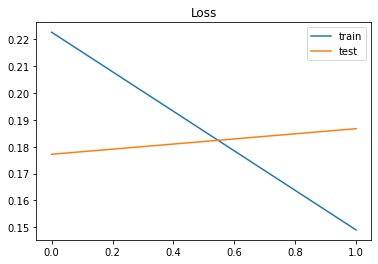

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

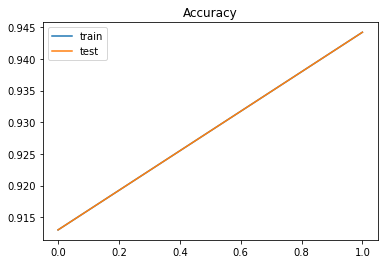

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis = 1)
Y_test = Y_test.argmax(axis = 1)

In [ ]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

### Text Classification using Fine-tuned BERT

In [ ]:
df_ex.head()

,label,review,clean_sentence,cut_sent
0,1,﻿更博了，爆照了，帅的呀，就是越来越爱你！生快傻缺[爱你][爱你][爱你],更博了爆照了帅的呀就是越来越爱你生快傻缺爱你爱你爱你,更博 爆照 帅 越来越 爱 生快 傻 缺爱 爱 爱
1,1,@张晓鹏jonathan 土耳其的事要认真对待[哈哈]，否则直接开除。@丁丁看世界 很是细心...,张晓鹏jonathan土耳其的事要认真对待哈哈否则直接开除丁丁看世界很是细心酒店都全部OK啦,张晓鹏 jonathan 土耳其 事要 认真对待 直接 开除 丁丁 看 世界 很 细心 酒店...
2,1,姑娘都羡慕你呢…还有招财猫高兴……//@爱在蔓延-JC:[哈哈]小学徒一枚，等着明天见您呢/...,姑娘都羡慕你呢还有招财猫高兴爱在蔓延JC哈哈小学徒一枚等着明天见您呢李欣芸SharonLee...,姑娘 都 羡慕 招财猫 高兴 爱 蔓延 JC 小 学徒 一枚 明天 见 李欣芸 Sharon...
3,1,美~~~~~[爱你],美爱你,美爱
4,1,梦想有多大，舞台就有多大![鼓掌],梦想有多大舞台就有多大鼓掌,梦想 大 舞台 大 鼓掌


In [ ]:
# Create sentence and label lists
sentences = df_ex.clean_sentence.values
# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df_ex.label.values

In [ ]:
labels

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

Tokenize the first sentence:
['[CLS]', '更', '博', '了', '爆', '照', '了', '帅', '的', '呀', '就', '是', '越', '来', '越', '爱', '你', '生', '快', '傻', '缺', '爱', '你', '爱', '你', '爱', '你', '[SEP]']


In [ ]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 120

In [ ]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [ ]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2020, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2020, test_size=0.2)

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
train_labels

tensor([1, 0, 1,  ..., 1, 0, 1])

In [ ]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-chinese", num_labels=2)
model.cuda()

Downloading:   0%|          | 0.00/393M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# exit()

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 2

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  6,000.    Elapsed: 0:00:12.
  Batch    80  of  6,000.    Elapsed: 0:00:25.
  Batch   120  of  6,000.    Elapsed: 0:00:37.
  Batch   160  of  6,000.    Elapsed: 0:00:50.
  Batch   200  of  6,000.    Elapsed: 0:01:03.
  Batch   240  of  6,000.    Elapsed: 0:01:16.
  Batch   280  of  6,000.    Elapsed: 0:01:29.
  Batch   320  of  6,000.    Elapsed: 0:01:42.
  Batch   360  of  6,000.    Elapsed: 0:01:55.
  Batch   400  of  6,000.    Elapsed: 0:02:09.
  Batch   440  of  6,000.    Elapsed: 0:02:22.
  Batch   480  of  6,000.    Elapsed: 0:02:36.
  Batch   520  of  6,000.    Elapsed: 0:02:50.
  Batch   560  of  6,000.    Elapsed: 0:03:04.
  Batch   600  of  6,000.    Elapsed: 0:03:18.
  Batch   640  of  6,000.    Elapsed: 0:03:32.
  Batch   680  of  6,000.    Elapsed: 0:03:46.
  Batch   720  of  6,000.    Elapsed: 0:03:59.
  Batch   760  of  6,000.    Elapsed: 0:04:13.
  Batch   800  of  6,000.    Elapsed: 0:04:27.
  Batch   840  of

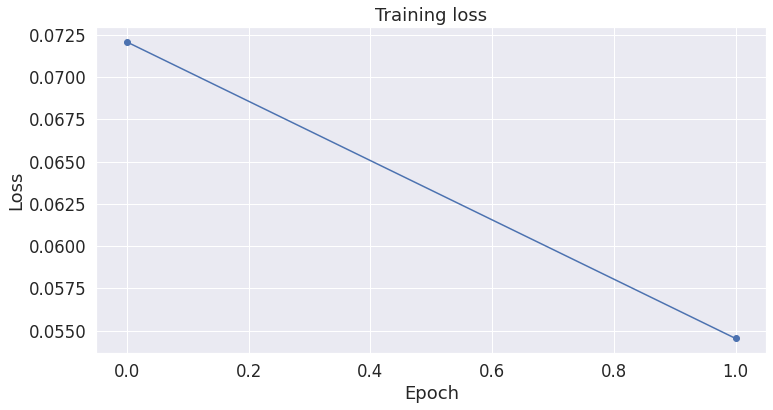

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='white')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits[0])
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.9978
Accuracy: 98.14%


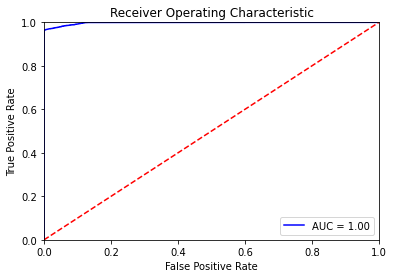

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(model, validation_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, validation_labels)

In [ ]:
%cd sentiment

/content/drive/MyDrive/Colab Notebooks/sentiment


In [ ]:
from transformers import TFBertForSequenceClassification, BertTokenizer 

MODEL_NAME = 'beto-sentiment-analysis'

tokenizer.save_pretrained('./{}_tokenizer/'.format(MODEL_NAME))
model.save_pretrained("./{}".format(MODEL_NAME), saved_model=True)

In [ ]:
from transformers import BertForSequenceClassification
model.save_pretrained('drive/MyDrive/Colab Notebooks/sentiment/')

In [ ]:
tokenizer.save_pretrained('drive/MyDrive/Colab Notebooks/sentiment/')

('drive/MyDrive/Colab Notebooks/sentiment/tokenizer_config.json',
 'drive/MyDrive/Colab Notebooks/sentiment/special_tokens_map.json',
 'drive/MyDrive/Colab Notebooks/sentiment/vocab.txt',
 'drive/MyDrive/Colab Notebooks/sentiment/added_tokens.json')

In [ ]:
model_new = BertForSequenceClassification.from_pretrained(
    "beto-sentiment-analysis", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

In [ ]:
from transformers import AutoTokenizer
tokenizer_new = AutoTokenizer.from_pretrained("beto-sentiment-analysis_tokenizer")

In [ ]:
work = pd.read_csv('total_cat.csv', error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
work.sample()

,id,ethnic,content,networking,job,culture,language,religion,admin,policy,max_index,category,max_score,second_score,second_index_name,diff,new_category,second_category
22802,22848,Zhuang,听歌学壮文壮语布依语Ahbuz最新壮语布依语原创歌曲阿婆啊阿婆我回来了您在哪儿Ahbuz阿婆...,0.781914,0.579237,0.687472,0.673243,0.554907,0.57223,0.389912,1,networking,0.781914,0.687472,culture,0.094442,networking,culture


In [ ]:
MAX_LEN = 128
batch_size = 32 
tokenizer = BertTokenizer.from_pretrained("beto-sentiment-analysis_tokenizer")
model = BertForSequenceClassification.from_pretrained("beto-sentiment-analysis", num_labels=2)
model.cuda()

def train(df):

    sentences = df['content']
    sentences_with_token = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
    
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences_with_token]

    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Create a mask of 1s for each token followed by 0s for padding
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask) 

    # Convert to tensors.
    prediction_inputs = torch.tensor(input_ids)
    prediction_masks = torch.tensor(attention_masks)
    
    # Create the DataLoader.
    prediction_data = TensorDataset(prediction_inputs, prediction_masks)
    prediction_dataloader = DataLoader(prediction_data, batch_size=batch_size)
    
    # Tracking variables 
    predictions = []

    # Predict 
    for batch in prediction_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask = batch

        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate predictions
            outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

        results = outputs[0]

        # Move logits and labels to CPU
        results = results.detach().cpu().numpy()

        # Store predictions and true labels
        predictions.append(results)

    return predictions

In [ ]:
predictions = train(work)

In [ ]:
predictions

[array([[ 1.3857998, -1.1206281],
        [ 1.4844027, -1.167185 ],
        [-2.1908727,  2.5169358],
        [-2.4663525,  2.7227259],
        [-1.410801 ,  2.0416496],
        [ 5.3712764, -4.297423 ],
        [-1.8541068,  2.2554255],
        [ 3.076539 , -2.8390536],
        [-1.1662836,  1.9101298],
        [-1.6609926,  2.1931906],
        [ 4.54439  , -3.9091382],
        [-1.1971008,  1.8662219],
        [-2.6274397,  2.920222 ],
        [-2.0900252,  2.538794 ],
        [-2.5271761,  2.8196259],
        [-2.6312127,  2.981798 ],
        [-2.33214  ,  2.6679971],
        [-3.664833 ,  3.681432 ],
        [-2.7554226,  2.9651637],
        [-3.3470755,  3.4233978],
        [ 1.1346362, -0.6475464],
        [-2.460216 ,  2.774077 ],
        [-1.5138913,  2.0698717],
        [-1.8102072,  2.262227 ],
        [-2.0311432,  2.4170432],
        [-1.820644 ,  2.26917  ],
        [-2.1217954,  2.4950368],
        [-1.7583737,  2.188261 ],
        [-1.968887 ,  2.3575506],
        [-2.88

In [ ]:
import itertools
# Get the prediction results
predictions_flat = list(itertools.chain.from_iterable(predictions))
prediction_set = []
for i in range(len(work)):
    prediction_set.append(np.argmax(predictions_flat[i]))
    
work['mis_prediction'] = prediction_set

In [ ]:
prediction_set

[0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [ ]:
xtra = {'sentiment': prediction_set}
df = work.append(pd.DataFrame(xtra))


In [ ]:
work['sentiment'] = prediction_set

In [ ]:
work.pop("sentiment")

0        0
1        0
2        1
3        1
4        1
        ..
47197    1
47198    1
47199    1
47200    1
47201    0
Name: sentiment, Length: 47202, dtype: int64

In [ ]:
work

,id,ethnic,content,networking,job,culture,language,religion,admin,policy,max_index,category,max_score,second_score,second_index_name,diff,new_category,second_category,mis_prediction
0,0,Tujia,教你如何识别苗族谎言一为什么说土家族是汉族教你识别苗族谎言二潘光旦教授到底说了什么苗族吧的经...,0.578994,0.345245,0.674394,0.649808,0.409921,0.580726,0.725370,7,policy,0.725370,0.674394,culture,0.050976,policy,culture,0
1,1,Tujia,做了三次基因检测三次的差别都好大我身份证上是土家族我奶奶是土家族但是我不会说土家族语言我外婆...,0.486153,0.245469,0.581896,0.577315,0.270995,0.421157,0.578090,3,culture,0.581896,0.578090,policy,0.003807,culture,policy,0
2,2,Tujia,是这个土家族吗是这个土家族吗,0.128054,-0.004236,0.342080,0.212377,0.138158,0.146179,0.309398,3,culture,0.342080,0.309398,policy,0.032682,culture,policy,1
3,3,Tujia,老调重弹土家族土司简史国中之国,0.142957,-0.051177,0.539788,0.320236,0.298905,0.076429,0.271466,3,culture,0.539788,0.320236,language,0.219552,culture,NaN,1
4,4,Tujia,老调重弹土家族土司简史国中之国鄂西南的土司政权元朝这里主要有散毛府至元二十年四月置1283年...,0.134904,0.238274,0.394705,0.176356,0.300622,0.081181,0.177253,3,culture,0.394705,0.300622,religion,0.094082,culture,religion,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47197,47260,Yi,彝族求讨论阿咪这个词的具体意思刘志一教授说古彝文和古越文已有9千年历史远远早于甲骨文等世界其...,0.302253,0.254013,0.711085,0.596890,0.412891,0.361182,0.533155,3,culture,0.711085,0.596890,language,0.114195,culture,language,1
47198,47261,Yi,彝族果基拉兹沈柯宇说你体育不及格你搞什么搞啊有点疑问南诏真的属于彝族么有没有系统的答案曾在大...,0.489484,0.407848,0.698342,0.539774,0.394563,0.553162,0.555249,3,culture,0.698342,0.555249,policy,0.143093,culture,policy,1
47199,47262,Yi,贷款彝族年的时候吃的这种烧烤把所有食材放到大盆里放上料搅拌然后烤那个料是什么啥料啊不就青油辣椒吗,0.540056,0.574627,0.528911,0.425248,0.457276,0.335670,0.181296,2,job,0.574627,0.540056,networking,0.034571,job,networking,1
47200,47263,Yi,彝族当下凉山彝族诗歌的内忧外患弟兄们都别胡乱讨论我族的历史了我族和汉族同样古老看汉语史书就有...,0.375754,0.290038,0.647758,0.459300,0.531111,0.405660,0.460158,3,culture,0.647758,0.531111,religion,0.116647,culture,religion,1


In [ ]:
work.to_csv("total_sent.csv")